In [1]:
#%pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv(r"amazon_alexa.tsv", delimiter = '\t', quoting = 3)
print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [4]:
data.head()


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
print(f"Feature names : {data.columns.values}")


Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [6]:
data.isnull().sum()


rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
data['verified_reviews'].isnull().sum()

np.int64(1)

In [8]:
data['verified_reviews'].head()

0                                        Love my Echo!
1                                            Loved it!
2    "Sometimes while playing a game, you can answe...
3    "I have had a lot of fun with this thing. My 4...
4                                                Music
Name: verified_reviews, dtype: object

In [9]:
data['verified_reviews'].mode()

0     
Name: verified_reviews, dtype: object

In [10]:
data['verified_reviews'].value_counts()

verified_reviews
                                                                                                                                                                                                                                                                                                               79
Love it!                                                                                                                                                                                                                                                                                                       22
Love it                                                                                                                                                                                                                                                                                                        19
Great product                                                    

In [11]:
data['verified_reviews'] = data['verified_reviews'].fillna(data['verified_reviews'].mode()[0])


In [12]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [13]:
data[data['verified_reviews'].isna() == True]


,rating,date,variation,verified_reviews,feedback


In [14]:
data.shape

(3150, 5)

In [15]:
data.dropna(inplace=True)


In [16]:
data.shape

(3150, 5)

In [17]:
data['length'] = data['verified_reviews'].apply(len)


In [18]:
data.head()


,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [19]:
print(f"'verified_reviews' column value: {data.iloc[10]['verified_reviews']}") #Original value
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
'length' column value : 65


In [20]:
data.dtypes


rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [21]:
len(data)


3150

In [22]:
print(f"Rating value count: \n{data['rating'].value_counts()}")


Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64


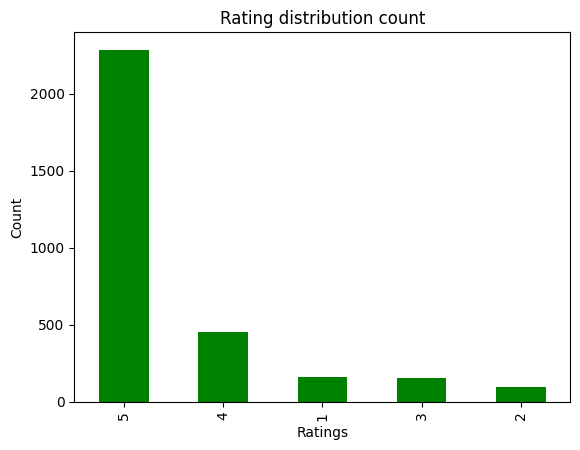

In [23]:
data['rating'].value_counts().plot.bar(color = 'green')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


In [24]:
print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")


Rating value count - percentage distribution: 
rating
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: count, dtype: float64


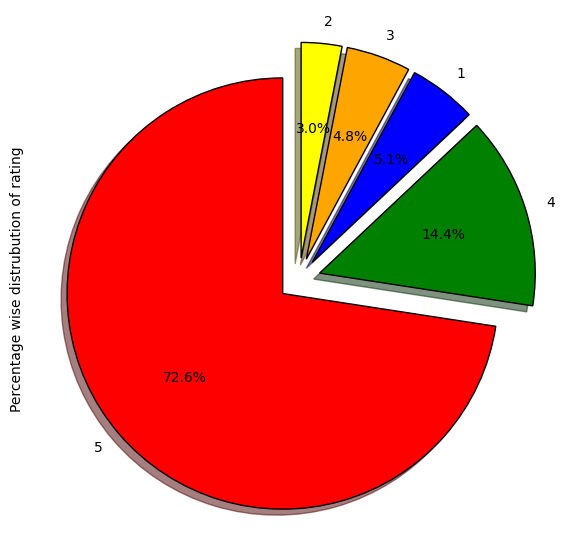

In [25]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [26]:
print(f"Feedback value count: \n{data['feedback'].value_counts()}")


Feedback value count: 
feedback
1    2893
0     257
Name: count, dtype: int64


In [27]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [28]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


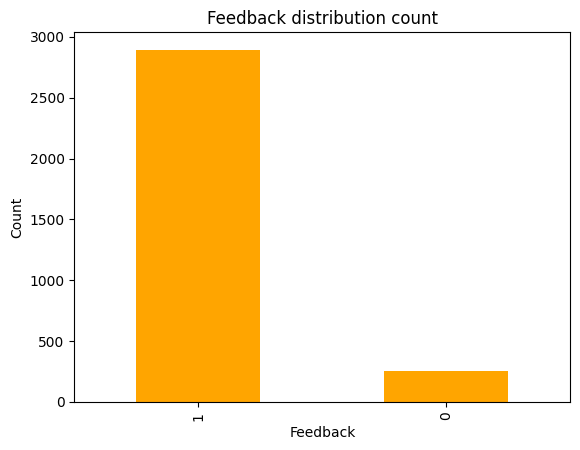

In [29]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'orange')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [30]:
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")


Feedback value count - percentage distribution: 
feedback
1    91.84
0     8.16
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

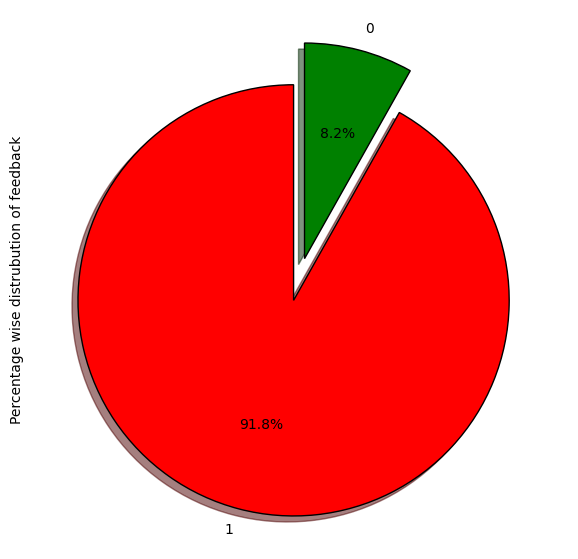

In [31]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [32]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     96
Name: count, dtype: int64

In [33]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [34]:
#Distinct values of 'variation' and its count 

print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


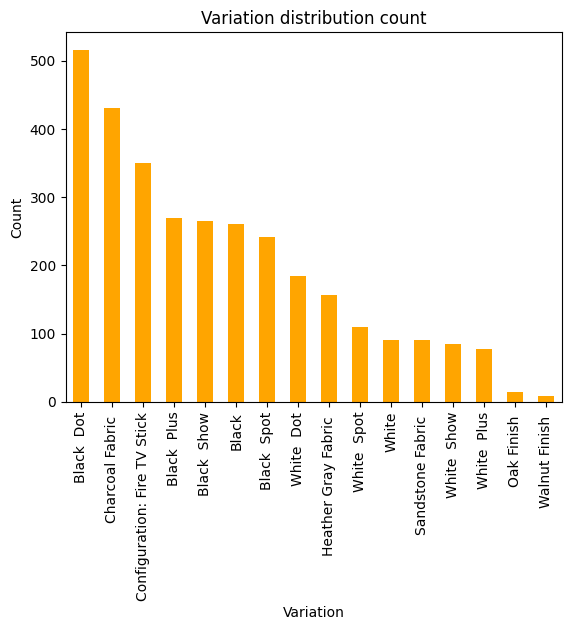

In [35]:
#Bar graph to visualize the total counts of each variation

data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [36]:
print(f"Variation value count - percentage distribution: \n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")


Variation value count - percentage distribution: 
variation
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [37]:
data.groupby('variation')['rating'].mean()


variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.142857
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

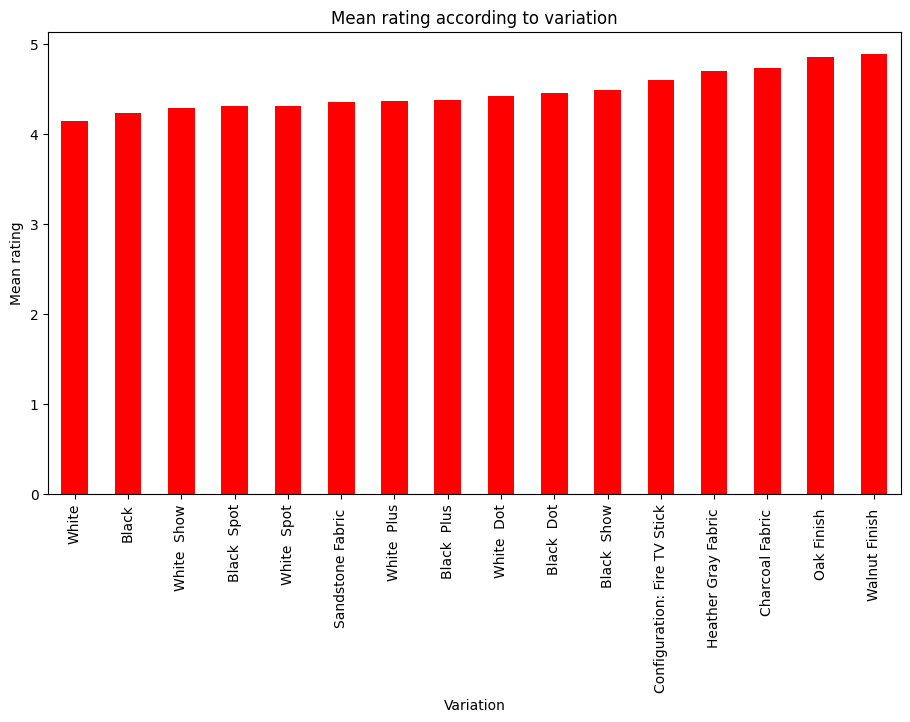

In [38]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'red', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [39]:
data['length'].describe()


count    3150.000000
mean      132.672698
std       182.527632
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

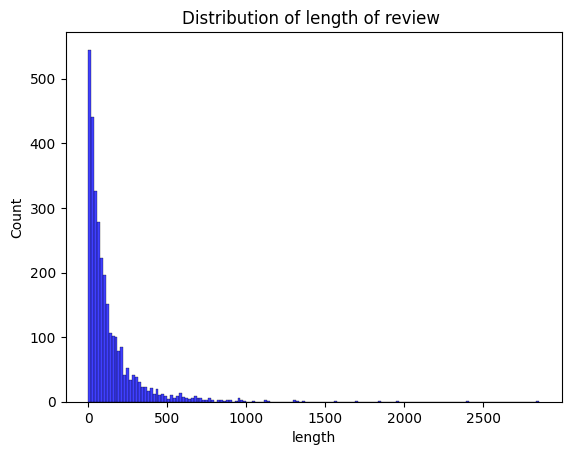

In [40]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

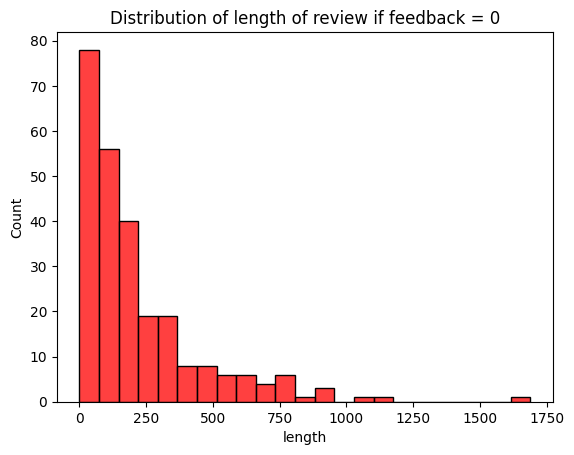

In [41]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')


[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

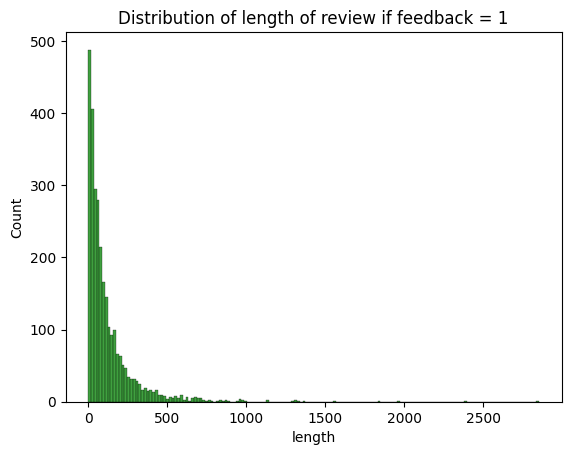

In [42]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')


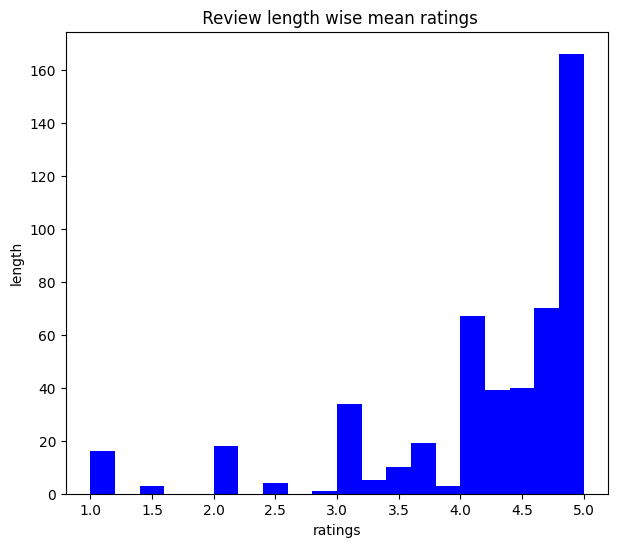

In [43]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [44]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

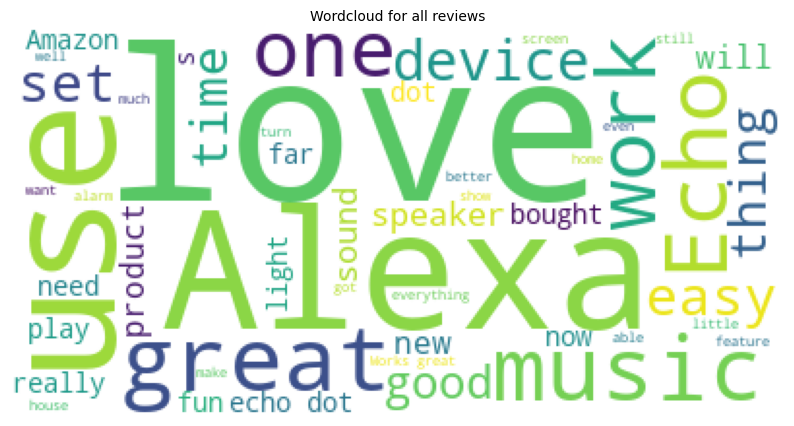

In [45]:
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()


In [46]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

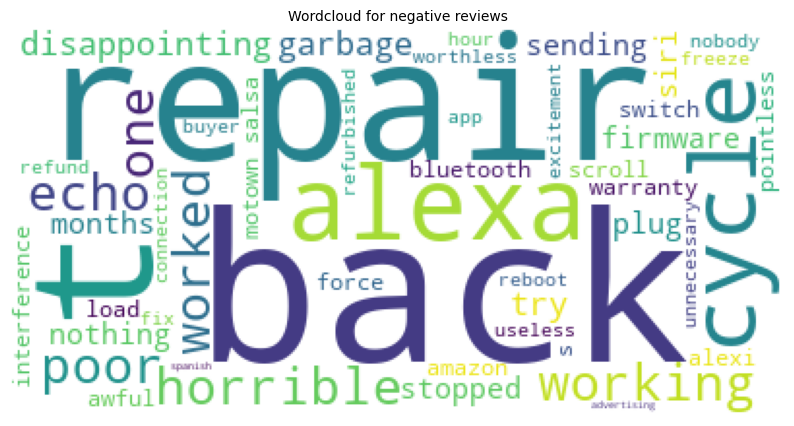

In [47]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

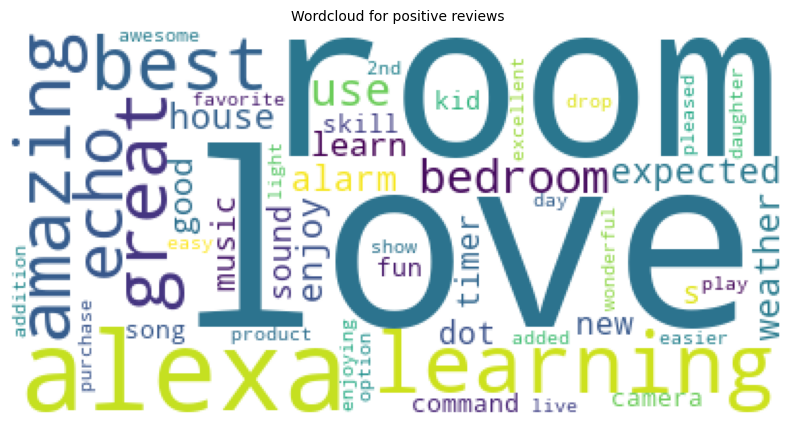

In [48]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [49]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [50]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [51]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))



In [52]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3150, 2500)
y shape: (3150,)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2205, 2500)
y train: (2205,)
X test: (945, 2500)
y test: (945,)


In [54]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [55]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [56]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))


In [57]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [58]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9936507936507937
Testing Accuracy : 0.9407407407407408


In [59]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [60]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

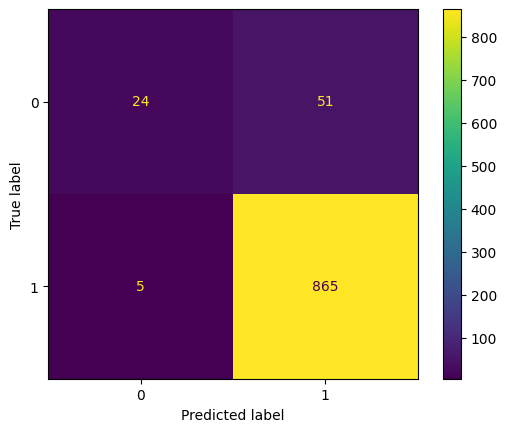

In [61]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [62]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9387844508432744
Standard Variance : 0.012316904611797585


In [63]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [64]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [65]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 300}


In [66]:

print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.89371648515103
Cross validation mean accuracy on test set : 92.3354913509271
Accuracy score for test set : 0.9407407407407408


In [67]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [68]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9714285714285714
Testing Accuracy : 0.9407407407407408


In [69]:
y_preds = model_xgb.predict(X_test)


In [70]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 24  51]
 [ 11 859]]


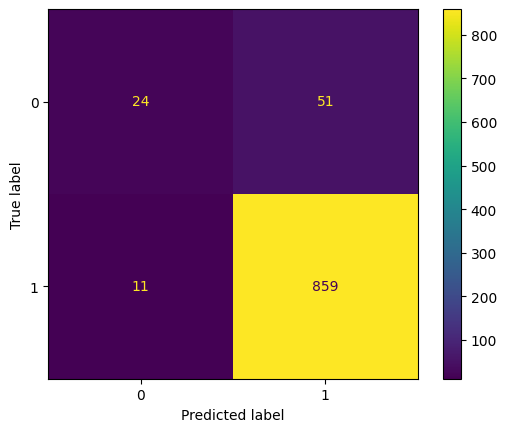

In [71]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [72]:
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))


In [73]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [74]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9936507936507937
Testing Accuracy : 0.9111111111111111


In [75]:
y_preds = model_dt.predict(X_test)


In [76]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 32  43]
 [ 67 803]]


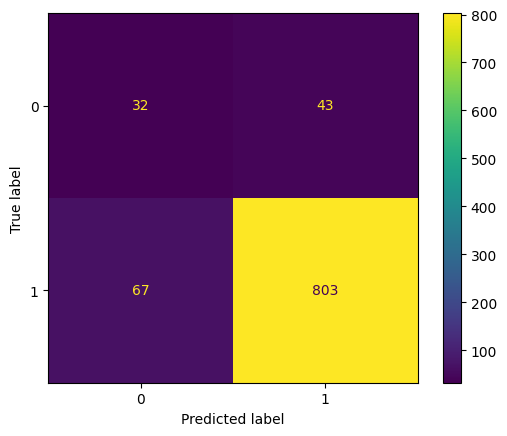

In [77]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [78]:
pip install vectorizer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import pickle
import numpy as np

# Download NLTK stopwords
nltk.download('stopwords')

# Load data
try:
    data = pd.read_csv("amazon_alexa.tsv", delimiter='\t', quoting=3)
except FileNotFoundError:
    print("Error: 'amazon_alexa.tsv' not found. Please ensure the dataset is in the current directory.")
    exit(1)

# Convert verified_reviews to string to handle NaN
data['verified_reviews'] = data['verified_reviews'].astype(str)

# Define stopwords and stemmer
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Preprocess reviews
corpus = []
for i in range(data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

# Vectorize
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

# Save vectorizer
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# Scale features
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# Save scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# Compute class weights to handle imbalance
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(f"Class weights: {class_weights}")

# Train XGBoost model with class weights
model_xgb = XGBClassifier(scale_pos_weight=class_weights[1]/class_weights[0])
model_xgb.fit(X_train_scl, y_train)

# Save model
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

# Evaluate on test set
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = model_xgb.predict(X_test_scl)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

print("Model retrained with class weights and .pkl files saved.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Class weights: {np.int64(0): np.float64(6.0576923076923075), np.int64(1): np.float64(0.5449826989619377)}
Test Accuracy: 0.8212
Confusion Matrix:
[[ 57  18]
 [151 719]]
Model retrained with class weights and .pkl files saved.


In [90]:
import re
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np

# Download NLTK stopwords
nltk.download('stopwords')

# Load the saved CountVectorizer, scaler, and XGBoost model
try:
    with open('countVectorizer.pkl', 'rb') as f:
        cv = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    with open('model_xgb.pkl', 'rb') as f:
        model_xgb = pickle.load(f)
except FileNotFoundError:
    print("Error: One or more .pkl files not found. Please ensure 'countVectorizer.pkl', 'scaler.pkl', and 'model_xgb.pkl' are in the current directory.")
    exit(1)

# Define stopwords and stemmer
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to preprocess a single review
def preprocess_review(review):
    if not isinstance(review, (str, bytes)):
        if isinstance(review, float) and np.isnan(review):
            return ""
        else:
            return str(review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    return review

# Input text review
new_review = "worst book"

# Debug: Check input type
print(f"Input review: {new_review}, Type: {type(new_review)}")

# Preprocess the input review
try:
    processed_review = preprocess_review(new_review)
    print(f"Processed review: '{processed_review}'")
except TypeError as e:
    print(f"Error processing review: {e}")
    exit(1)

# Check if processed review is empty
if not processed_review.strip():
    print(f"Warning: The review '{new_review}' resulted in an empty processed text. Prediction may be unreliable.")
    print("Defaulting to NEGATIVE due to lack of meaningful content.")
    prediction = [0]
else:
    # Debug: Check if words are in vocabulary
    vocab = cv.vocabulary_
    words = processed_review.split()
    for word in words:
        print(f"Is '{word}' in vocabulary? {word in vocab} (Index: {vocab.get(word, 'Not found')})")

    # Transform the review using CountVectorizer
    X_new = cv.transform([processed_review]).toarray()
    print(f"Feature vector sum: {X_new.sum()} (Non-zero features: {np.count_nonzero(X_new)})")

    # Check if the feature vector is sparse
    if X_new.sum() == 0:
        print(f"Warning: The review '{new_review}' contains no words in the model's vocabulary. Prediction may be unreliable.")
        print("Defaulting to NEGATIVE due to sparse input.")
        prediction = [0]
    else:
        # Scale the features using MinMaxScaler
        X_new_scl = scaler.transform(X_new)

        # Predict sentiment using the XGBoost model
        prediction = model_xgb.predict(X_new_scl)

# Output the result
if prediction[0] == 1:
    print(f"The review '{new_review}' is predicted to be POSITIVE.")
else:
    print(f"The review '{new_review}' is predicted to be NEGATIVE.")

Input review: worst book, Type: <class 'str'>
Processed review: 'worst book'
Is 'worst' in vocabulary? True (Index: 2468)
Is 'book' in vocabulary? True (Index: 211)
Feature vector sum: 2 (Non-zero features: 2)
The review 'worst book' is predicted to be NEGATIVE.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
